In [851]:
import json
import pandas as pd
import numpy as np
import pymongo
import os.path
import seaborn as sns
import re
import matplotlib.pyplot as plt
import string
import scipy.sparse as sp
import time

from scipy.stats import wilcoxon
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, metrics
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

tqdm_notebook().pandas()
sns.set_context('talk')
sns.set_style("whitegrid", {'axes.grid' : False})
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

%matplotlib inline

# Load data

## Control and treatment groups

###  Load users information

In [2]:
n_users = pd.read_csv("./nosport_users_stats")
s_users = pd.read_csv("./sport_users_stats")

for df in [n_users, s_users]:
    df.index = df['id']

In [3]:
s_users.shape, n_users.shape

((1160, 7), (1160, 7))

### Load matches

Load matches file.

In [4]:
matches = pd.read_csv("/data/1/sporty/users/classification/matches.txt", header=None, names=['sport', 'nosport'])

Some users have been matched twice to a sport users, we remove these duplicate entries here although we missed them in 2014.

In [5]:
matches = matches.drop_duplicates(subset=['nosport'])
n_users = n_users.drop_duplicates(subset=['id'])

Align users' dataframes.

In [6]:
s_users = s_users.loc[matches.sport.tolist()]
s_users.index = np.arange(s_users.shape[0])
n_users = n_users.loc[matches.nosport.tolist()]
n_users.index = np.arange(n_users.shape[0])

In [7]:
s_users.shape, n_users.shape

((1153, 7), (1153, 7))

Remove users that are in both groups and their match that we missed last time.

In [8]:
# find users in both groups
both_groups = set(s_users['id']) & set(n_users['id'])

# find lines with users in both groups
s_idx_to_remove = s_users.id.where(s_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
n_idx_to_remove = n_users.id.where(n_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
idx_to_remove = s_idx_to_remove + n_idx_to_remove

# remove lines from users' dataframes
s_users = s_users.drop(idx_to_remove, axis=0)
n_users = n_users.drop(idx_to_remove, axis=0)

In [9]:
s_users.shape, n_users.shape

((1137, 7), (1137, 7))

### Load tweets for each user 

For each user, load scraped tweets, without auto-generated tweets by physical applications, and removing retweets.

In [51]:
def load_tweets(user_id, data_dir, remove_hash=None, keep_rt=False):
    user_p = os.path.join(data_dir, user_id)
    tweets = []
    with open(user_p) as fd:
        for l in fd:
            o = json.loads(l)
            # check for retweets
            if not keep_rt and 'retweeted_status' in o:
                keep_tw = False
            else:
                # check for hashtags to avoid
                h = set([_['text'].lower() for _ in o['entities']['hashtags']])
                keep_tw = remove_hash is None or not (h & set(remove_hash))
            
            if keep_tw:
                tweets.append(o['text'])
    return tweets
    
auto_hash = ['runkeeper', 'nikeplus', 'runtastic', 'endomondo', 'mapmyrun', 'strava', 'cyclemeter', 'fitstats', 'mapmyfitness', 'runmeter']

def load_tweets_sport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/sport/", remove_hash=auto_hash)
    
def load_tweets_nosport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/no_sport/", remove_hash=auto_hash)

In [60]:
s_users['tweets'] = s_users.id.astype(str).progress_apply(load_tweets_sport)
n_users['tweets'] = n_users.id.astype(str).progress_apply(load_tweets_nosport)

In [75]:
s_users['tweets_count'] = s_users.tweets.apply(len)
n_users['tweets_count'] = n_users.tweets.apply(len)

Drop users' (and their match) that have no remaining tweets.

In [594]:
notweets_nidx = n_users.index[n_users.tweets_count == 0].tolist()
notweets_sidx = s_users.index[s_users.tweets_count == 0].tolist()
notweets_idx = notweets_nidx + notweets_sidx

In [604]:
s_users = s_users.drop(notweets_idx)
n_users = n_users.drop(notweets_idx)

## Mood annotated data

In [86]:
def load_labeled_mood(p):
    tweets = []
    with open(p) as fd:
        for l in tqdm_notebook(fd):
            o = json.loads(l)
            tweets.append({k: o[k] for k in ['text', 'AH', 'DD', 'TA']})
    return pd.DataFrame(tweets)

mood_tweets_df = load_labeled_mood("/data/1/sporty/tweets/labeled/3K_labeled")

### Load LIWC lexicon

In [91]:
''' Data structure and utility functions for reading and querying a LIWC
lexicon. Data described here:
http://homepage.psy.utexas.edu/homepage/faculty/pennebaker/reprints/LIWC2001.pdf
'''

from collections import defaultdict
import os


class Lexicon(object):
    """
    >>> import tempfile
    >>> tf = tempfile.NamedTemporaryFile()
    >>> tf.write("%\\n1\\tPronoun\\n2\\tI\\n3\tGreet\\n%\\ni\\t01 02\\nhis\\t01\\nhi*\t03")
    >>> tf.flush()
    >>> d = Lexicon(tf.name)
    >>> d.categories_for_tokens(['i', 'his'])
    [[u'Pronoun', u'I'], [u'Pronoun']]
    >>> d.categories_for_tokens(['his'])
    [[u'Pronoun']]
    >>> cts = d.counts_for_tokens(['i', 'his'])
    >>> cts[u'I']
    1
    >>> cts[u'Pronoun']
    2
    >>> d.categories_for_tokens(['zebra'])
    [[]]
    >>> d.categories_for_tokens(['hithere'])
    [[u'Greet']]
    """

    def __init__(self, dict_file=None):
        self.dict_file = dict_file
        self.load_dictionary(dict_file)

    def parse_categories(self, catText):
        lines = catText.split("\n")
        self.categories = {}
        for line in lines:
            if len(line) > 0:
                key, val = line.split()
                self.categories[str(key)] = str(val)

    def parse_patterns(self, regExps):
        lines = regExps.split("\n")
        self.exact_patterns = {}
        self.prefix_patterns = {}
        for line in lines:
            if len(line) > 0 and not line.startswith('//'):
                vals = line.split()
                exp = vals[0]
                ids = [str(int(v)) for v in vals[1:]]
                if '*' in exp:
                    self.prefix_patterns[exp[:-1]] = ids
                else:
                    self.exact_patterns[exp] = ids

    def load_dictionary(self, dict_file):
        dict_text = open(dict_file).read()
        as_list = dict_text.split("%")
        self.parse_categories(as_list[1])
        self.parse_patterns(as_list[2])

    def categories_for_token(self, word):
        result = []
        if word in self.exact_patterns:
            result.extend(self.exact_patterns[word])
        else:
            for i in range(0, len(word)):
                if word[:-i] in self.prefix_patterns:
                    result.extend(self.prefix_patterns[word[:-i]])
        return [self.categories[c] for c in result]

    def categories_for_tokens(self, tokens):
        """ Returns a list of lists. For each token, create a list of categories
        it belongs to."""
        return [self.categories_for_token(token) for token in tokens]

    def counts_for_tokens(self, tokens):
        """ Returns a dict mapping categories to counts from this list of
        tokens. """
        cats = self.categories_for_tokens(tokens)
        d = defaultdict(lambda: 0)
        for a in cats:
            for b in a:
                d[b] += 1
        return d
    
lex = Lexicon("./liwc.dic")

###  Load emoticons 

In [115]:
emoticon_df = pd.read_csv("emoticons", sep=" ", header=None, names=['tag', 'emoticon'], index_col=1)
emoticon_dict = emoticon_df.to_dict(orient='dict')['tag']

###  Build features encoding

Build tokenizer

In [1043]:
def tokenize(text, keep_hashtags=False, keep_mentions=True, keep_urls=True,
             collapse_hashtags=True, collapse_mentions=True, collapse_urls=True, collapse_digits=True, 
             limit_repeats=True, bigrams=True, liwc=True):
    punc = string.punctuation + "—“"
    text = re.sub("\s+", " ", text.lower())
    if not keep_hashtags:
        text = re.sub('#\S+', '', text)
    elif collapse_hashtags:
        text = re.sub('#\S+', 'HASHTAG', text)
    else:
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        
    if not keep_mentions:
        text = re.sub('@\S+' , '', text)
    elif collapse_mentions:
        text = re.sub('@\S+', 'MENTION', text)
    
    if not keep_urls:
        text = re.sub('http\S+', '', text)
    elif collapse_urls:
        text = re.sub('http\S+', 'URL', text)
    
    if limit_repeats:
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
    if collapse_digits:
        text = re.sub(r'[0-9]+', 'NUMBER', text)
    splits = text.split()
    
    punc_tokens = []
    word_tokens = []
    liwc_tokens = []
    for tok in splits:
        if tok in emoticon_dict:
            word_tokens.append(emoticon_dict[tok])
        elif keep_mentions and tok[0] == '@':
            word_tokens.append(tok)
        else:
            tok = tok.strip(punc)
            if tok:
                word_tokens.append(tok)
        if liwc:
            liwc_tokens.extend(["LIWC_" + _ for _ in lex.categories_for_token(tok)])
    
    liwc_tokens = list(set(liwc_tokens))
    bigram_tokens = ["_".join(_) for _ in zip(word_tokens, word_tokens[1:])] if bigrams else []
    
    return word_tokens + bigram_tokens + liwc_tokens

### Build classifier for each dimension

Apply to 3 mood dimensions.

In [797]:
moods = ['AH', 'DD', 'TA']
vecs = {}
kbests = {}
plines = {}
Xs = {}
clfs = {}
features = {}
top_features = {}
n_features = 'all'

for m in tqdm_notebook(moods):
    # build pipeline
    vecs[m] = TfidfVectorizer(tokenizer=tokenize, min_df=2, binary=True)
    kbests[m] = SelectKBest(chi2, n_features)
    plines[m] = pipeline = Pipeline([('tfidf', vecs[m]), ('chi2', kbests[m])])
    
    # build doc term matrix
    y = mood_tweets_df[m]
    Xs[m] = plines[m].fit_transform(mood_tweets_df.text, y)
    # get labels

    # train classifier
    clfs[m] = LogisticRegression(class_weight='balanced')
    clfs[m].fit(Xs[m],y)
    
    # retrieve features
    support = kbests[m].get_support()
    features[m] = np.array(vecs[m].get_feature_names())[support]
    top_features[m] = [(features[m][i], clfs[m].coef_[0][i]) for i in clfs[m].coef_[0].argsort()[::-1]]

###  Top features for each dimension

In [800]:
for m in moods:
    print("Top features for", m)
    for i, (w,c) in enumerate(top_features[m][:20]):
        print("{:>5}. {:.<40}{:>4}".format(i, w, "%.3f" % c))
    print('-'*100)

Top features for AH
    0. LIWC_Anger..............................4.666
    1. hate....................................3.326
    2. LIWC_Swear..............................3.254
    3. dumb....................................3.114
    4. your....................................2.797
    5. upset...................................2.745
    6. fuck....................................2.419
    7. LIWC_Negemo.............................2.386
    8. rude....................................2.295
    9. bitch...................................2.291
   10. irritated...............................2.283
   11. shit....................................2.113
   12. shut....................................2.105
   13. fucking.................................2.016
   14. ignorant................................1.865
   15. why.....................................1.763
   16. stupid..................................1.703
   17. being...................................1.698
   18. freakin............

### Cross validation

In [801]:
def cv(data, n_folds=10):
    results = {}

    for m in tqdm_notebook(moods):
        y_probs = []
        y_preds = []
        y_trues = []
        for tr, te in tqdm_notebook(KFold(data.shape[0], n_folds, shuffle=True, random_state=123456)):
            data_tr, data_te = data.iloc[tr], data.iloc[te]
            y_tr, y_te = data_tr[m], data_te[m]
            X_tr = plines[m].fit_transform(data_tr.text, y_tr)

            X_te = plines[m].transform(data_te.text)

            clf = LogisticRegression(class_weight='balanced')
            clf.fit(X_tr, y_tr)
            y_prob = clf.predict_proba(X_te)[:,1]
            y_pred = clf.predict(X_te)

            y_trues.extend(y_te)
            y_preds.extend(y_pred)
            y_probs.extend(y_prob)
    
        results[m] = {'y_true': y_trues, 'y_pred': y_preds, 'y_prob': y_probs}
    return results

In [802]:
results_cv = cv(mood_tweets_df, 10)

ROC curves for each dimension.

AH ROC AUC: 0.863
DD ROC AUC: 0.846
TA ROC AUC: 0.824


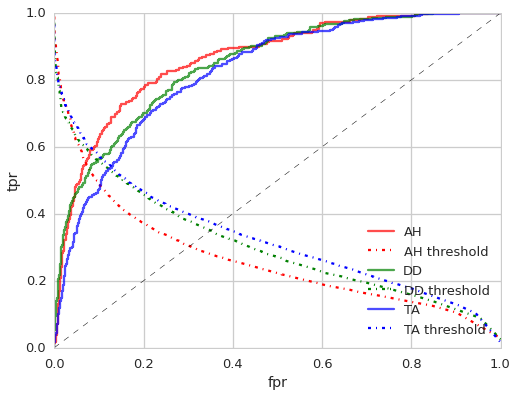

In [828]:
def roc_curves(results):
    fig, ax = plt.subplots(figsize=(8,6))
    colors = ['r','g','b']
    for m, c in zip(moods,colors):
        fpr, tpr, thresh = metrics.roc_curve(results[m]['y_true'], results[m]['y_prob'], drop_intermediate=True)
        ax.plot(fpr, tpr, label=m, color=c, alpha=0.7)
        ax.plot(fpr, thresh, label=m + " threshold", linestyle='-.', color=c)
        plt.legend(loc=4)
        print("%s ROC AUC: %.3f" % (m, metrics.roc_auc_score(results[m]['y_true'], results[m]['y_prob'])))
    ax.set_ylim([0,1])
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.plot([0,1],[0,1], color='k', linestyle='--', linewidth=0.5)
        
roc_curves(results_cv)

Precision recall curve for each dimension.

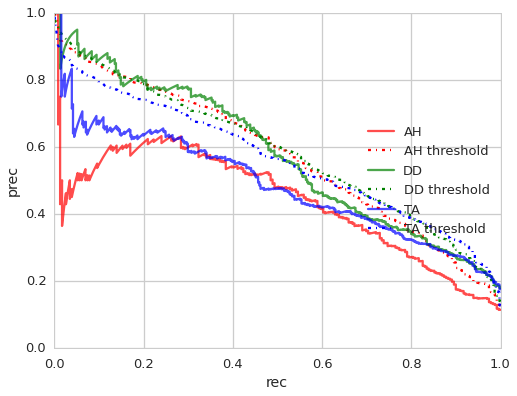

In [829]:
def prec_rec_curves(results):
    fig, ax = plt.subplots(figsize=(8,6))
    colors = ['r','g','b']
    for m, c in zip(moods,colors):
        prec, rec, thresh = metrics.precision_recall_curve(results[m]['y_true'], results[m]['y_prob'], pos_label=1)
        thresh = np.hstack([thresh, [1]])
        ax.plot(rec, prec, label=m, color=c, alpha=0.7)
        ax.plot(rec, thresh, label=m + " threshold", linestyle='-.', color=c)
        plt.legend(loc=7)
    ax.set_ylim([0,1])
    ax.set_xlabel('rec')
    ax.set_ylabel('prec')
        
prec_rec_curves(results_cv)

Pick threshold for best precision (tp/(tp+fp)), minimize false positives.

In [809]:
thresholds = {'AH': .5, 'DD': .5, 'TA': .5}
# thresholds = {'AH': .1, 'DD': .22, 'TA': .18}
# thresholds = {'AH': .6, 'DD': .6, 'TA': .6}
# thresholds = {'AH': .99, 'DD': .99, 'TA': .99}

for m in moods:
    print(m)
    t = thresholds[m]
    y_pred_thresh = (np.array(results_cv[m]['y_prob']) > t).astype(int)
    print(y_pred_thresh.sum())
    print(metrics.classification_report(results_cv[m]['y_true'], y_pred_thresh))

AH
341
             precision    recall  f1-score   support

          0       0.96      0.91      0.93      2138
          1       0.40      0.60      0.48       229

avg / total       0.90      0.88      0.89      2367

DD
546
             precision    recall  f1-score   support

          0       0.93      0.85      0.89      1998
          1       0.44      0.64      0.52       369

avg / total       0.85      0.81      0.83      2367

TA
555
             precision    recall  f1-score   support

          0       0.92      0.84      0.88      1986
          1       0.42      0.61      0.50       381

avg / total       0.84      0.80      0.82      2367



## Annotate users from treatment and control groups.

Train classifiers on the all the annotated instances.

In [810]:
moods = ['AH', 'DD', 'TA']
vecs = {}
kbests = {}
plines = {}
Xs = {}
clfs = {}
features = {}
top_features = {}
n_features = 160

for m in tqdm_notebook(moods):
    # build pipeline
    vecs[m] = TfidfVectorizer(tokenizer=tokenize, min_df=3, max_df=0.95)
    kbests[m] = SelectKBest(chi2, n_features)
    plines[m] = pipeline = Pipeline([('tfidf', vecs[m]), ('chi2', kbests[m])])
    
    # build doc term matrix
    y = mood_tweets_df[m]
    Xs[m] = plines[m].fit_transform(mood_tweets_df.text, y)
    # get labels

    # train classifier
    clfs[m] = LogisticRegression(class_weight='balanced')
    clfs[m].fit(Xs[m],y)
    
    # retrieve features
    support = kbests[m].get_support()
    features[m] = np.array(vecs[m].get_feature_names())[support]
    top_features[m] = [(features[m][i], clfs[m].coef_[0][i]) for i in clfs[m].coef_[0].argsort()[::-1]]

Build termdoc matrix for each user.

In [811]:
for m in tqdm_notebook(moods):
    f = lambda _: plines[m].transform(_)
    n_users['termdoc_' + m] = n_users.tweets.progress_apply(f)
    s_users['termdoc_' + m] = s_users.tweets.progress_apply(f)

Scale termdoc matrix and compute probability of each class for each user.

In [812]:
for m in tqdm_notebook(moods):
    f = lambda _: clfs[m].predict_proba(_)
    n_users['prob_' + m] = n_users['termdoc_' + m].progress_apply(f)
    s_users['prob_' + m] = s_users['termdoc_' + m].progress_apply(f)    

Compute average score for each user.

In [813]:
f = lambda _: np.mean(_[:,1])

for m in tqdm_notebook(moods):
    n_users['avg_prob_' + m] = n_users['prob_' + m].apply(f)
    s_users['avg_prob_' + m] = s_users['prob_' + m].apply(f)

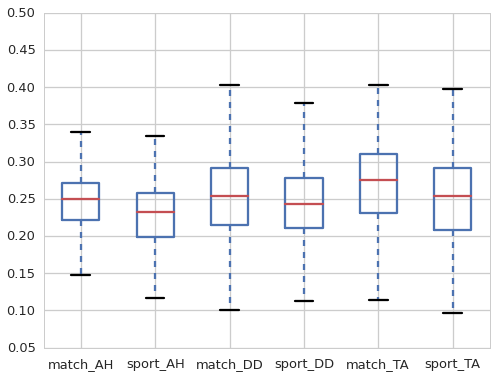

In [827]:
compare_avg_df = pd.DataFrame()
for m in moods:
    compare_avg_df['match_' + m] = n_users['avg_prob_' + m]
    compare_avg_df['sport_' + m] = s_users['avg_prob_' + m]
#     compare_avg_df['diff_' + m] = n_users['avg_prob_' + m] - s_users['avg_prob_' + m]
    
compare_avg_df.plot(kind='box', figsize=(8,6))#, ylim=[-0.1,.22])

Percent change

In [819]:
def perc_change(before, after):
    return 100 * (after - before) / before

for m in moods:
    before = n_users['avg_prob_' + m].mean()
    after = s_users['avg_prob_' + m].mean()
    w, p = wilcoxon(n_users['avg_prob_' + m], s_users['avg_prob_' + m])
    print("Dimension {}: {}% Change, p-value = {}".format(m, "%.2f" % perc_change(before, after), "%.3g" % p))

Dimension AH: -6.48% Change, p-value = 1.76e-22
Dimension DD: -3.64% Change, p-value = 4.84e-06
Dimension TA: -7.05% Change, p-value = 3.29e-16


Compute prediction for each tweets for each user given a threshold for each dimension.

In [820]:
thresholds = {'AH': .5, 'DD': .5, 'TA': .5}

for m in tqdm_notebook(moods):
    t = thresholds[m]
    f = lambda _: (_[:, 1] > t).astype(int)
    n_users['pred_' + m] = n_users['prob_' + m].apply(f)
    s_users['pred_' + m] = s_users['prob_' + m].apply(f)

Compute ratio of positive tweets for each dimension and each user.

In [822]:
f = lambda _: np.sum(_)/np.shape(_)[0]
for m in tqdm_notebook(moods):
    n_users['ratio_pos_' + m] = n_users['pred_' + m].apply(f)
    s_users['ratio_pos_' + m] = s_users['pred_' + m].apply(f)    

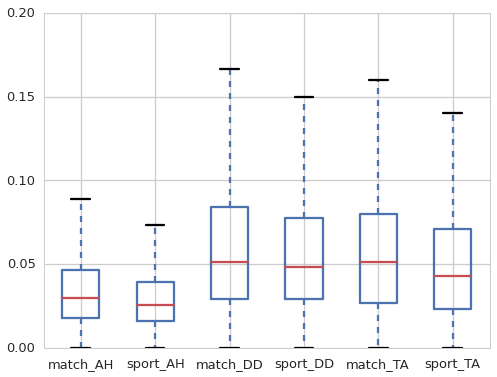

In [826]:
compare_ratio_df = pd.DataFrame()
for m in moods:
    compare_ratio_df['match_' + m] = n_users['ratio_pos_' + m]
    compare_ratio_df['sport_' + m] = s_users['ratio_pos_' + m]
#     compare_ratio_df['diff_' + m] = n_users['ratio_pos_' + m] - s_users['ratio_pos_' + m]
    
compare_ratio_df.plot(kind='box', figsize=(8,6), ylim=[0,.2])

# Topic analysis 

## Clustering helpers

In [522]:
def kmeans_top_fts(kmeans, X, feature_names, n_top_features):
    df = pd.DataFrame()
    X_sum = X.sum(axis=0).A1
    for cl_i in range(kmeans.n_clusters):
        in_cluster_i = np.where(kmeans.labels_ == cl_i)
        X_sum_i = X[in_cluster_i].sum(axis=0).A1
        top_fts_idx = np.argsort(X_sum_i)[::-1]
        df['cluster_%d' % (cl_i + 1)] = feature_names[top_fts_idx][:n_top_features]
    
    return df

In [465]:
def cluster_users_tweets(users, col='tweets', n_clusters=10, max_iter=10, n_words=50, seed=123456, stop_words='english',
                         tokenize_kwargs=dict(keep_hashtags=True, collapse_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False)):
    t0 = time.time()
    print("Vectorize data...")
    vec = TfidfVectorizer(analyzer='word', tokenizer=lambda _: tokenize(_, **tokenize_kwargs),
                          binary=True, min_df=3, max_df=.95, max_features=50000, stop_words=stop_words)
    col_obj = users[col] if type(col) is str else col
    X = vec.fit_transform(col_obj.apply(lambda _: " ".join(_)))
    t1 = time.time()
    print("Done in %.2fs." % (t1-t0))
    feature_names = np.array(vec.get_feature_names())
    print("%d features." % len(feature_names))
    print("Run KMeans clustering...")
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=seed)
    kmeans.fit(X)
    t2 = time.time()
    print("Done in %.2fs." % (t2-t1))
    
    return vec, feature_names, X, kmeans, kmeans_top_fts(kmeans, X, feature_names, n_words)

## Load food-related datasets

### FooDB dataset

In [1044]:
foodb_foods = pd.read_csv("foodb_2016-11-18/foods.csv", escapechar="\\")
colors = set(['blue', 'red', 'green', 'yellow', 'orange', 'white', 'black'])
food_parts = foodb_foods.name.str.lower()\
                        .apply(lambda _: re.sub(r'[%s]' % re.escape(string.punctuation), "", _).split())\
                        .apply(lambda _: "_".join([x for x in _ if x not in colors]))

In [1045]:
foodb_flavors = pd.read_csv("foodb_2016-11-18/flavors.csv")
flavor_parts = foodb_flavors.name.str.lower()\
                        .apply(lambda _: re.sub(r'[%s]' % re.escape(string.punctuation), "", _).split())\
                        .apply(lambda _: "_".join([x for x in _ if x not in colors]))

In [1046]:
foodb_words = set(food_parts.unique()) | set(flavor_parts.unique())

### Filter using FooDB keywords then use taxonomy tagging to remove ambiguous tweets (E.g. tweets about apple, the company)

In [1566]:
def load_weber_lexicon(p):
    line_sep = "==="
    add_to_df = False
    collected = []
    with open(p) as fd:
        for l in fd:
            l = l.strip()
            if l:
                if l.startswith(line_sep):
                    add_to_df = not add_to_df
                    continue
                if add_to_df:
                    collected.append(l.strip().split('\t'))
    df = pd.DataFrame(collected, columns=['food_name', 'avg_cal_per_serving', 'food_cat'])
    df['food_name'] = df.food_name.apply(lambda _: "_".join(_.split()))
    df.avg_cal_per_serving.astype(float, inplace=True)
    return df

weber_lexicon = set(load_weber_lexicon("./twitter_food_calorie_lexicon.txt").food_name)
weber_df = load_weber_lexicon("./twitter_food_calorie_lexicon.txt")

In [1568]:
weber_df

,food_name,avg_cal_per_serving,food_cat
0,pizza,477.8,Fast Foods
1,tea,16.84,Beverages
2,coffee,34.4,Beverages
3,ice_cream,157.24,Dairy
4,icecream,157.24,Dairy
5,sour_cream,67.24,Dairy
6,chicken,488.12,Poultry
7,cheese,176.64,Dairy
8,cola,65.84,Beverages
9,egg,147.76,Dairy


In [1615]:
food_dict = defaultdict(lambda: '')
merge_cat_dict = {'spices and herbs': 'herbs and spices'}
merge_cat = lambda c: merge_cat_dict[c] if c in merge_cat_dict.keys() else c
for i, r in foodb_foods.iterrows():
    food_dict["_".join(r['name'].lower().split())] = merge_cat(r.food_group.lower())
for i, r in foodb_flavors.iterrows():
    food_dict["_".join(r['name'].lower().split())] = '' if type(r.flavor_group) is float else merge_cat(r.flavor_group.lower())
for i, r in weber_df.iterrows():
    food_dict[r.food_name] = merge_cat(r.food_cat.lower())

In [1048]:
exclude_words = set( # targeting apple, blackberry, kevin bacon, raspberry pi
    [
        'phone', 'iphone', 'itunes', 'google', 'app', 'kevin', 'os', 'ios', 'ipad', 'samsung', 'android', 'pi', 'apps', 'software',
        'cisco', 'smartphone', 'mobile', 'nest', 'iwatch', 'media', 'nexus'
    ]
)
exclude_words |= set( # direct ban of ambiguous words
    [
        'apple', 'raspberry', 'blackberry', 'kevin'
    ]
)

def tw_filter(tw, include, exclude=[], keep_rt=False):
    tokens  = set(tokenize(tw, keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False))
    if 'rt' in tokens and not keep_rt:
        return False
    include = set(include)
    exclude = set(exclude)
    if not (tokens & exclude) and (tokens & include):
        return True
    else:
        return False

n_users['food_tweets'] = n_users.tweets.progress_apply(lambda _: [tw for tw in _ if tw_filter(tw, foodb_words | weber_lexicon, exclude_words)])
s_users['food_tweets'] = s_users.tweets.progress_apply(lambda _: [tw for tw in _ if tw_filter(tw, foodb_words | weber_lexicon, exclude_words)])

In [1217]:
import textblob
from textblob.wordnet import *

food_wn = set([Synset('food.n.01'), Synset('food.n.02'), Synset('edible_nut.n.01')])#, Synset('consume.v.02')])
amibguous_words = [ # ambiguous words classify as food-related words by wordnet
    'stock', 'b', 'cs', 'ds', 'as', 'd', 'e', 'a', 'es', 'c', 'bs'
    'lap','bib','try','cod','ade','leg','cos','sup','mix', 'pap',
    'ail','zep','sub','fed','soy','dog','msg','bap','pop','cut','pud',
    'jak','poi','has','roe','had','hay','gem','yam','lox','cup','hit','rue',
    'must', 'game', 'center', 'shoulder', 'date', 'buffalo', 'green', 'white',
    'bootleg', 'snowball', 'centre', 'coloring', 'kisses', 'games', 'rose',
    'sucker'
]
dp_food_words = {w:False for w in amibguous_words}

def word_isin(w, cats):
    cats    = set(cats)
    w       = textblob.Word(w)
    synsets = w.synsets
    
    visited = set()
    
    # word has been searched before
    if w in dp_food_words:
        return dp_food_words[w]
    
    while synsets:
        insert_parents = True
        cursyn = synsets.pop(0)
        visited.add(cursyn)
        
        # synset has been seen before
        if cursyn in dp_food_words:
            if dp_food_words[cursyn]:
                # add word to our dp dict
                dp_food_words[w] = True
                return True
            else:
                continue
        
        # synset matches our categories
        if cursyn in cats:
            dp_food_words[cursyn] = True
            #print(cursyn, True)
            return True
        # synset does not match our categories
        else:
            parents = cursyn.hypernyms()
            #print("%s <- %s" % (cursyn, parents))
            synsets.extend(parents)
    
    # if we find a word that doesn't match our categories, we know that none of the
    # visited synset match our categories
    dp_food_words[w] = False
    for syn in visited:
        dp_food_words[syn] = False
    return False

In [1218]:
def wn_fraction(tw, cats):
    tokens = tokenize(tw, liwc=False, keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False)
    #tokens = tw.lower().split()
    matches = np.array([1 if word_isin(tk, cats) else 0 for tk in tokens])
    return np.sum(matches)/matches.shape[0]

n_users['wn_fraction_food'] = n_users.food_tweets.progress_apply(lambda l: [wn_fraction(tw, food_wn) for tw in l])
s_users['wn_fraction_food'] = s_users.food_tweets.progress_apply(lambda l: [wn_fraction(tw, food_wn) for tw in l])

In [1219]:
def parse_k(k):
    r = str(k).lower()
    if type(k) == textblob.Word:
        pass
    elif type(k) == nltk.corpus.reader.wordnet.Synset:
        if r.startswith('synset'):
            r = r.split("'")[1]
    return r

dft = pd.DataFrame([{'name':parse_k(k), 'is_food': v} for k, v in dp_food_words.items()])
dft.index = dft['name']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43e21c3dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f43e224aac8>]], dtype=object)

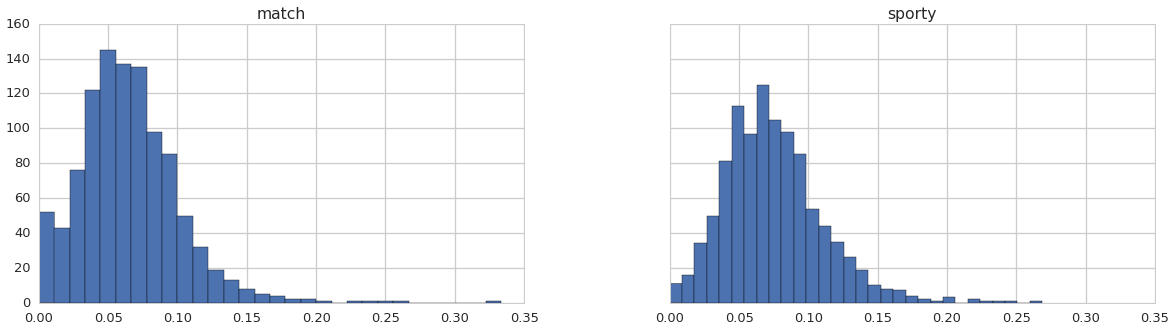

In [1231]:
wn_fractions_df = pd.DataFrame([
        n_users['wn_fraction_food'].apply(lambda _: np.mean(_) if _ else 0),
        s_users['wn_fraction_food'].apply(lambda _: np.mean(_) if _ else 0)
    ],
                               index=['match', 'sporty']).T
wn_fractions_df.hist(alpha=1, bins=30, figsize=(20,5), sharey=True, sharex=True, )

In [1232]:
def filter_out_wn_ratio(row, thresh):
    return [tw for tw, ratio in zip(row.food_tweets, row.wn_fraction_food) if ratio >= thresh]

ratio_thresh = 0.15
count_thresh = 15
n_wn_ratio_tweets = n_users.apply(lambda _: filter_out_wn_ratio(_, ratio_thresh), axis=1)
s_wn_ratio_tweets = s_users.apply(lambda _: filter_out_wn_ratio(_, ratio_thresh), axis=1)

keep_idx = ((n_wn_ratio_tweets.apply(len) > count_thresh) & (s_wn_ratio_tweets.apply(len) > count_thresh))
n_wn_ratio_tweets = n_wn_ratio_tweets[keep_idx]
s_wn_ratio_tweets = s_wn_ratio_tweets[keep_idx]
print("Keeping tweets with a score of at least %.2f and users with at least %d remaining tweets." % (ratio_thresh, count_thresh))
print("Yield %d users per group." % n_wn_ratio_tweets.shape[0])

Keeping tweets with a score of at least 0.15 and users with at least 15 remaining tweets.
Yield 424 users per group.


#### K-means clustering

In [1469]:
stopwords_punc = pd.read_csv("./stopwords_punc", header=None, names=['word']).word.tolist()
stopwords_punc += [_.replace("'", "’") for _ in stopwords_punc]
all_wn_ratio_tweets = n_wn_ratio_tweets.append(s_wn_ratio_tweets)

vec_n, features_n, X_n, kmeans_n, kmeans_top_fts_n = cluster_users_tweets(n_users, n_wn_ratio_tweets, n_clusters=10, max_iter=300, stop_words=stopwords_punc,
                                                                          tokenize_kwargs=dict(keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False, ))
vec_s, features_s, X_s, kmeans_s, kmeans_top_fts_s = cluster_users_tweets(s_users, s_wn_ratio_tweets, n_clusters=10, max_iter=300, stop_words=stopwords_punc,
                                                                          tokenize_kwargs=dict(keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False))
vec_a, features_a, X_a, kmeans_a, kmeans_top_fts_a = cluster_users_tweets(None, all_wn_ratio_tweets, n_clusters=10, max_iter=300, n_words=1000, stop_words=stopwords_punc,
                                                                          tokenize_kwargs=dict(keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False))

Vectorize data...
Done in 0.46s.
4716 features.
Run KMeans clustering...
Done in 1.38s.
Vectorize data...
Done in 0.52s.
5156 features.
Run KMeans clustering...
Done in 1.58s.
Vectorize data...
Done in 0.93s.
7784 features.
Run KMeans clustering...
Done in 11.12s.


In [1470]:
kmeans_top_fts_a[:30]

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,grey,made,chicken,cheese,popcorn,beer,others,keurig,sweet,coffee
1,vintage,sauce,just,like,filipino,cream,w,bacon,NUMBER,like
2,gasoline,soup,dinner,cream,ever,night,pic,grab,coffee,cake
3,goose,salad,sweet,now,colorful,taco,NUMBER,sweet,cream,pizza
4,wade,oil,NUMBER,ice,side,ice,amp,hm,beer,water
5,performance,recipe,coffee,good,adobo,NUMBER,company,miracle,chicken,really
6,jeff,green,pizza,chocolate,sweet,deck,beer,agreed,pizza,butter
7,hops,garlic,w,just,free,chocolate,coffee,drink,like,just
8,blame,potatoes,ice,right,NUMBER,good,grill,line,water,hot
9,zombie,spinach,hot,food,coke,dinner,cream,😃,ice,sweet


#### LDA topics 

In [1471]:
from sklearn.decomposition import LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    df = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        df['topic_%d' % topic_idx] = feature_names[topic.argsort()[::-1]][:n_top_words]
    return df

lda = LatentDirichletAllocation(n_topics=10, max_iter=30,
                            learning_method='online', 
                            learning_offset=3.,
                            random_state=0)

In [1472]:
lda.fit(X_n)
print_top_words(lda, features_n, 10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,sandwich,ham,cake,dave,cool,chicken,sugar,coffee,problems,hey
1,house,red,sweet,pie,pasta,chocolate,barrel,sweet,indoor,pounds
2,chips,pork,chicken,logic,yes,make,pictured,pizza,mold,pineapple
3,anyone,coffee,time,bacon,cream,donuts,grill,NUMBER,sweet,orange
4,goodie,whole,steak,philz,taco,friday,seriously,cream,♫,new
5,sidewalk,yum,coffee,hacks,potato,dinner,cup,just,one,vinegar
6,hot,m,pumpkin,praying,now,apples,today,like,♥,house
7,lunch,spice,best,nice,love,peanut,away,chicken,amp,beer
8,day,restaurant,good,yeah,chocolate,just,ice,good,chocolate,run
9,made,sausage,day,less,chips,crab,headline,chocolate,stars,bar


In [1473]:
lda.fit(X_s)
print_top_words(lda, features_s, 10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,pizzeria,sweet,day,running,peanut,chops,grab,one,sweet,water
1,side,NUMBER,new,milk,EMOTICONSMILE,lobster,really,three,dinner,fish
2,fingers,chicken,breakfast,appealing,tea,bitter,looks,baked,breakfast,chicken
3,seriously,coffee,burrito,to…,roof,jalepeno,just,week,NUMBER,stuff
4,says,cream,oregon,bean,one,style,beer,roll,good,bacon
5,free,pizza,night,jelly,cookies,sauce,deep,peanut,egg,drinking
6,prices,ice,cheese,chilly,ever,cookin,sick,snowman,cream,cake
7,veggies,just,great,tablet,rain,without,bacon,apples,yum,just
8,pack,water,turkey,sandwich,cinnamon,rabbit,like,tomato,coffee,cheese
9,yes,beer,pork,making,salt,dropping,drink,amp,beer,meat


## Find most discriminative features

In [1474]:
from sklearn.preprocessing import LabelEncoder

In [1475]:
# vectorized tweets
X_a
# create label
users_per_group = len(n_wn_ratio_tweets)
y_a = np.zeros((2*users_per_group))
y_a[users_per_group:] = 1

# debug classes
g = n_users.gender[keep_idx].as_matrix()
g = np.hstack([g,g])

In [1476]:
X_af, y_af = X_a[g == 'f'], y_a[g == 'f']
X_am, y_am = X_a[g == 'm'], y_a[g == 'm']

### Chi2

In [1616]:
def most_discrim_chi2(X,y,features,n):
    x2, pval = chi2(X, y)
    sorted_idx = x2.argsort()
    sorted_idx = sorted_idx[:(x2 >= 0).sum()]
    sorted_idx = [i for i in sorted_idx if x2[i] != np.nan]
    print(len(sorted_idx))
    keep = sorted_idx[::-1][:n]
    top_fts = features[keep]
    top_coef = x2[keep]
    df = pd.DataFrame()
    df['feature_name'] = top_fts
    df['chi2'] = top_coef
    return df

In [1617]:
# most_discrim_chi2(X_a, y_a, features_a, 50)
# most_discrim_chi2(X_af, y_af, features_a, 50)
most_discrim_chi2(X_a, y_a, features_a, 50)

7784


,feature_name,chi2
0,il,1.505800
1,wow,1.119201
2,changed,0.950711
3,roof,0.850138
4,loss,0.844856
5,rogue,0.841368
6,insanely,0.838494
7,candies,0.814222
8,state,0.810065
9,soap,0.801720


### Classifier 

In [1618]:
def most_discrim_lr(X,y,features,n):
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X,y)
    print(clf.coef_.shape)
    sorted_idx = clf.coef_[0].argsort()
    df = pd.DataFrame()

    # for class 0
    df['match'] = features[sorted_idx][:n]
    df['coef_match'] = clf.coef_[0][sorted_idx][:n]
    df['is_food_match'] = df.match.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    
    # for positive class
    df['sporty'] = features[sorted_idx][::-1][:n]
    df['coef_sporty'] = clf.coef_[0][sorted_idx][::-1][:n]
    df['is_food_sporty'] = df.sporty.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    return df

from sklearn.svm import SVC

def most_discrim_svm(X,y,features,n):
    clf = SVC(class_weight='balanced', kernel='linear')
    clf.fit(X,y)
    coefs = clf.coef_.toarray()[0]
    sorted_idx = coefs.argsort()
    df = pd.DataFrame()

    # for class 0
    df['match'] = features[sorted_idx][:n]
    df['coef_match'] = coefs[sorted_idx][:n]
    df['is_food_match'] = df.match.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    
    # for positive class
    df['sporty'] = features[sorted_idx][::-1][:n]
    df['coef_sporty'] = coefs[sorted_idx][::-1][:n]
    df['is_food_sporty'] = df.sporty.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    return df

In [1619]:
t = most_discrim_svm(X_a, y_a, features_a, 2000)
t.head(20)

,match,coef_match,is_food_match,sporty,coef_sporty,is_food_sporty
0,wish,-1.260070,False,wow,1.711945,False
1,last,-1.227190,False,others,1.479707,False
2,fan,-1.223253,False,burrito,1.471663,True
3,table,-1.219065,True,cookies,1.334649,True
4,dude,-1.165469,False,cafe,1.268969,False
5,corner,-1.137240,False,man,1.266488,False
6,anyone,-1.082022,False,lots,1.256110,False
7,pops,-1.081927,True,il,1.247604,False
8,absolutely,-1.077075,False,looks,1.199785,False
9,bananas,-1.042416,True,photo,1.176884,False


In [1620]:
tn = t[(t.is_food_match == True)][["match", "coef_match"]]
tn

,match,coef_match
3,table,-1.219065
7,pops,-1.081927
9,bananas,-1.042416
13,whiskey,-0.959577
20,rabbit,-0.855482
22,chip,-0.835962
24,mozzarella,-0.828242
25,stick,-0.824629
28,curds,-0.822269
36,candies,-0.778151


In [1621]:
ts = t[(t.is_food_sporty == True)][["sporty","coef_sporty"]]
ts

,sporty,coef_sporty
2,burrito,1.471663
3,cookies,1.334649
10,breakfast,1.149003
18,broccoli,1.021440
19,scratch,1.015826
22,seafood,0.968092
26,almond,0.907317
27,onions,0.901569
32,burgers,0.877193
33,kale,0.875698


In [1643]:
tn['food_cat'] = tn.match.progress_apply(lambda _: Counter([c for k,c in food_dict.items() if (_ in k or _[:-1] in k) and c]).most_common(1)).apply(lambda _: _[0][0] if _ else None)
ts['food_cat'] = ts.sporty.progress_apply(lambda _: Counter([c for k,c in food_dict.items() if (_ in k or _[:-1] in k) and c]).most_common(1)).apply(lambda _: _[0][0] if _ else None)

# = tn.merge(weber_df, how='left', left_on='match', right_on='food_name').dropna(subset=['food_cat'])
# t2['avg_cal_per_serving'] = t2.avg_cal_per_serving.astype(float)
# g2 = t2.groupby("food_cat")

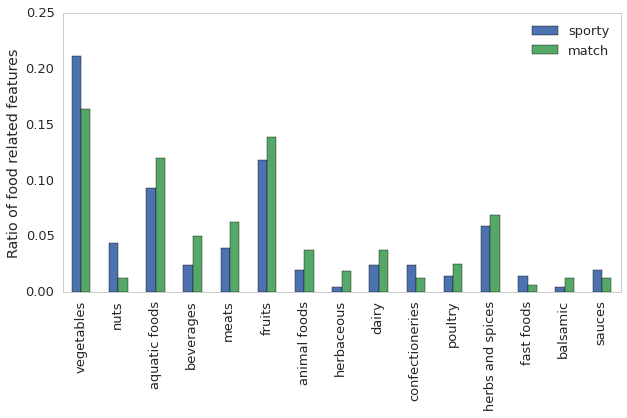

In [1652]:
df = pd.DataFrame()
df['sporty'] = ts.food_cat.value_counts()
df['sporty'] /= df.sporty.sum()
df['match']  = tn.food_cat.value_counts()
df['match'] /= df.match.sum()
df['diff'] = np.abs(df.sporty - df.match)
df = df.sort_values(by='diff', ascending=False)
df = df[['sporty','match']]

df = df[:15]
ax = df.plot(kind='bar', figsize=(10,5))
ax.set_ylabel("Ratio of food related features")

# bars = ax.patches
# hatches = ''.join(h*len(df) for h in '-/')

# for bar, hatch in zip(bars, hatches):
#     bar.set_hatch(hatch)
# ax.legend(loc='center right')

## Load good guides and exemplars data 

### Collect list of people followed by each users 

In [1262]:
with open("twitterauth.json") as fd:
    creds = json.load(fd)

In [1263]:
import tweepy

auth = tweepy.OAuthHandler(creds['consumer_key'], creds['consumer_secret'])
auth.set_access_token(creds['access_token'], creds['access_token_secret'])
api = tweepy.API(auth)

In [ ]:
def collect_friends_ids(uid):
    p = "/data/1/sporty/users/friends_ids/%d" % uid
    file_missing = not os.path.exists(p)
    if file_missing or os.path.getsize(p) == 0:
        with open(p, 'w') as fd:
            try:
                l = api.friends_ids(id=uid)
                for fid in l:
                    fd.write("%d\n" % fid)
                time.sleep(60) # avoid reaching rate limit of 15 requests per 15 minute window
            except:
                time.sleep(60) # wait more because rate limit has been reached
                
# n_users[keep_idx].id.progress_apply(collect_friends_ids)
# s_users[keep_idx].id.progress_apply(collect_friends_ids)

In [1264]:
def load_friends_list(uid):
    p = "/data/1/sporty/users/friends_ids/%d" % uid
    friends = []
    if os.path.exists(p):
        with open(p) as fd:
            for l in fd:
                friends.append(int(l.strip()))
    return friends
        
n_users['friends'] = n_users[keep_idx].id.apply(load_friends_list)
s_users['friends'] = s_users[keep_idx].id.apply(load_friends_list)

### Good guides

In [1265]:
good_guides_df = pd.read_excel("./goodguide.xlsx", names=['screen_name', 'name', 'sector', 'eco_score', 'health_score'])

In [1266]:
good_guides_df = good_guides_df[(good_guides_df.sector == 'Food') & ~(good_guides_df.health_score.isnull())]

In [1267]:
good_guides_set = set(good_guides_df.screen_name)

### Exemplars

In [1268]:
exemplars_set = set(pd.read_csv("exemplars.txt", header=None)[0])

### Collect user informations for each nutrition-related handle

In [1269]:
nutrition_handles_set = good_guides_set | exemplars_set

In [1270]:
# recipe to iterate over any iterable by chunks of n
from itertools import zip_longest
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

### Loads ids of nutrition related accounts 

In [1271]:
import glob

def load_nutrition_ids(re_path, limit_to=None):
    nutrition_uids = {}
    for p in glob.glob(re_path):
        with open(p) as fd:
            u = json.loads(fd.readline())
            if limit_to is None or u['screen_name'] in limit_to:
                nutrition_uids[u['screen_name']] = u['id']
    return nutrition_uids


good_guides_dict = load_nutrition_ids("/data/1/sporty/users/nutrition_users/*", good_guides_set)
exemplars_dict = load_nutrition_ids("/data/1/sporty/users/nutrition_users/*", exemplars_set)
good_guides_ids = set(good_guides_dict.values())
exemplars_ids = set(exemplars_dict.values())

## Analyze food-related friends and mentions for each group 

### Build lists of nutrition friends

In [1286]:
n_users['exemplar_friends'] = n_users.friends.apply(lambda l: l if type(l) == float else [_ for _ in l if _ in exemplars_ids])
s_users['exemplar_friends'] = s_users.friends.apply(lambda l: l if type(l) == float else [_ for _ in l if _ in exemplars_ids])

n_users['good_guides_friends'] = n_users.friends.apply(lambda l: l if type(l) == float else [_ for _ in l if _ in good_guides_ids])
s_users['good_guides_friends'] = s_users.friends.apply(lambda l: l if type(l) == float else [_ for _ in l if _ in good_guides_ids])

### Compare exemplar friends

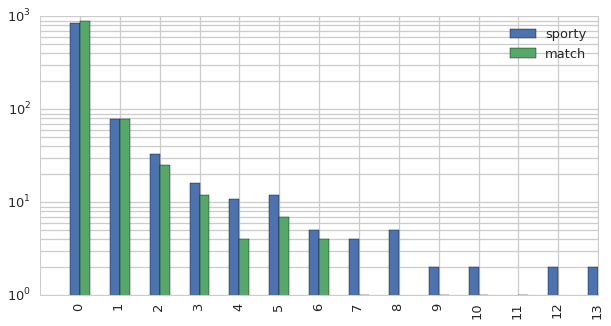

In [1287]:
exemplars_friends_df = pd.DataFrame()
exemplars_friends_df['sporty'] = s_users.exemplar_friends.apply(lambda _: 0 if type(_) is float else len(_))
exemplars_friends_df['match']  = n_users.exemplar_friends.apply(lambda _: 0 if type(_) is float else len(_))

fig, ax = plt.subplots(figsize=(10,5))
xl = [-1,13]
exemplars_friends_df.apply(lambda _: _.value_counts().sort_index()).plot(kind='bar', alpha=1, ax=ax, logy=True)
# exemplars_friends_df.plot(kind='kde', xlim=xl, ax=ax, secondary_y=True)
ax.set_xlim(xl)
ax.grid(True)
ax.grid(b=True, which='minor')

### Compare good guides friends

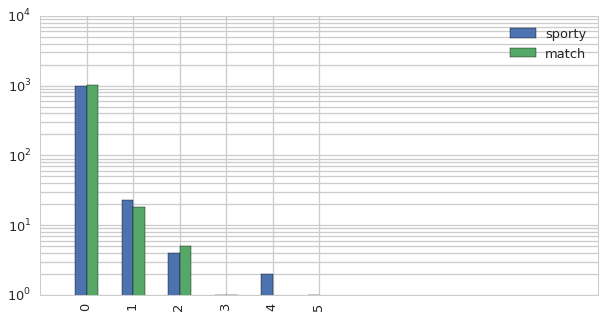

In [1288]:
good_guides_friends_df = pd.DataFrame()
good_guides_friends_df['sporty'] = s_users.good_guides_friends.apply(lambda _: 0 if type(_) is float else len(_))
good_guides_friends_df['match']  = n_users.good_guides_friends.apply(lambda _: 0 if type(_) is float else len(_))

fig, ax = plt.subplots(figsize=(10,5))
xl = [-1,11]
good_guides_friends_df.apply(lambda _: _.value_counts().sort_index()).plot(kind='bar', ax=ax, logy=True)
ax.set_xlim(xl)
ax.grid(True)
ax.grid(True, which='minor')

### Compare exemplars + good_guides friends

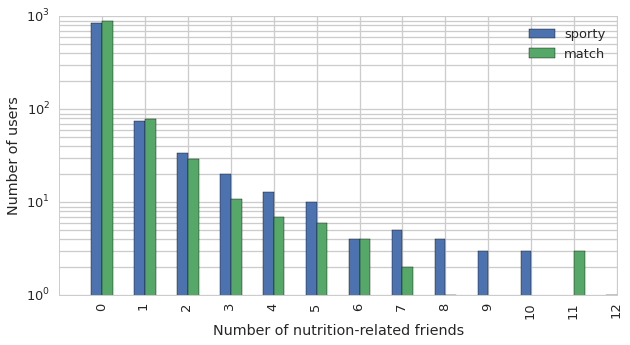

In [1289]:
nutrition_friends_df = good_guides_friends_df + exemplars_friends_df


fig, ax = plt.subplots(figsize=(10,5))
xl = [-1,12]
nutrition_friends_df.apply(lambda _: _.value_counts().sort_index()).plot(kind='bar', ax=ax, logy=True)
# nutrition_friends_df.plot(kind='kde', xlim=xl, ax=ax, secondary_y=True)
ax.set_xlim(xl)
ax.grid(True)
ax.grid(True, which='minor')
ax.set_xlabel("Number of nutrition-related friends")
ax.set_ylabel("Number of users")

In [1290]:
nutrition_friends_df.describe()

,sporty,match
count,1034.000000,1034.000000
mean,0.633462,0.411992
std,2.618735,2.205443
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,52.000000,41.000000


In [1291]:
wilcoxon(nutrition_friends_df.sporty, nutrition_friends_df.match)

WilcoxonResult(statistic=8250.5, pvalue=2.8708279712290629e-05)

In [1292]:
nutrition_diff = (nutrition_friends_df.sporty - nutrition_friends_df.match)
nutrition_diff.describe()

count    1034.000000
mean        0.221470
std         3.046316
min       -38.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        49.000000
dtype: float64

### Filter mentions and simple count

#### On all tweets of all users

In [1293]:
mentions_re = re.compile("^@[0-9a-zA-Z\-_]+")
nutrition_handles_set_lower = set([_.lower() for _ in nutrition_handles_set])
nutrition_tokenize = lambda tw: tokenize(tw, collapse_mentions=False, bigrams=False, liwc=False, limit_repeats=False, keep_mentions=True)
n_mentions = n_users.tweets.progress_apply(lambda l: [tk for tw in l for tk in nutrition_tokenize(tw) if mentions_re.match(tk) and tk[1:] in nutrition_handles_set_lower])
s_mentions = s_users.tweets.progress_apply(lambda l: [tk for tw in l for tk in nutrition_tokenize(tw) if mentions_re.match(tk) and tk[1:] in nutrition_handles_set_lower])

In [1294]:
mentions_df = pd.DataFrame()
mentions_df['sporty'] = s_mentions.apply(len)
mentions_df['match'] = n_mentions.apply(len)
mentions_diff = mentions_df.sporty - mentions_df.match
mentions_df.describe()

,sporty,match
count,1034.000000,1034.000000
mean,1.923598,0.886847
std,11.056441,4.382240
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,287.000000,88.000000


In [1295]:
wilcoxon(mentions_df.match, mentions_df.sporty)

WilcoxonResult(statistic=33851.0, pvalue=1.8705573795922336e-09)

In [1296]:
mentions_diff.describe()

count    1034.000000
mean        1.036750
std        11.510785
min       -85.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       287.000000
dtype: float64

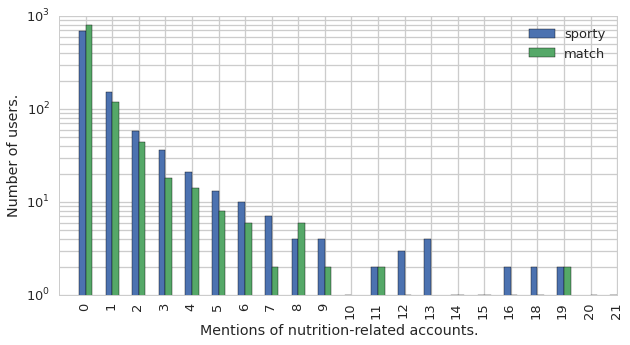

In [1297]:
fig, ax = plt.subplots(figsize=(10,5))
xl = [-1,20]
mentions_df.apply(lambda _: _.value_counts().sort_index()).plot(kind='bar', ax=ax, logy=True)
ax.set_xlim(xl)
ax.grid(True)
ax.grid(True, which='minor')
ax.set_xlabel("Mentions of nutrition-related accounts.")
ax.set_ylabel("Number of users.")